# 네이버 감정분석

# 환경
* Ubuntu 18.04
* TensorFlow 2.4.1
* scikit learn 0.23.0
* numpy 1.19.5
* Keras 2.4.3
* conda 4.10.1

# 루브릭 평가기준

|평가문항|상세기준|
|------|---|
|1. 다양한 방법으로 Text Classification task를 성공적으로 구현했다.|3가지 이상의 모델이 성공적으로 시도됨|
|2. gensim을 활용하여 자체 학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

# 패키지 및 라이브러리 불러오기

In [1]:
import glob
import os
import re
import numpy as np
import pandas as pd

from collections import Counter

import urllib.request
from konlpy.tag import Okt, Mecab

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

from gensim.models import KeyedVectors
import gensim
from sklearn.model_selection import train_test_split

from keras.layers import Bidirectional, LSTM, GRU, Dense, Conv1D
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 1) 데이터 준비와 확인

In [2]:
%pwd

'/aiffel/aiffel/sentiment_classification'

In [3]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성
* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
print(len(X_train)) 
print(len(y_train)) 
print('-'*15)
print(len(X_test))
print(len(y_test))
print('-'*40)
print('word_to_index : ',len(word_to_index), type(word_to_index))

146182
146182
---------------
49157
49157
----------------------------------------
word_to_index :  9997 <class 'dict'>


In [6]:
# word_to_index를 확인해보면 PAD, BOS, UNK가 생략되어 있어서
# <PAD>, <BOS>, <UNK>를 차례대로 0, 1, 2와 같이 dictionary에 포함시킨다.

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown

# word_to_index

In [7]:
# word_to_index를 index_to_word로 변환

index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[0])
print(word_to_index["<PAD>"])
print('-'*30)
print(index_to_word[6])
print(word_to_index["다"])
print('-'*30)
print(index_to_word[5])
print(word_to_index["영화"])

<PAD>
0
------------------------------
다
6
------------------------------
영화
5


# 3) 모델 구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
total_data_test = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_test]
num_tokens = np.array(num_tokens)

# 문장 길이의 분포 확인
print('문장길이 평균:', np.mean(num_tokens))
print('문장길이 최대:', np.max(num_tokens))
print('문장길이 표준편차:', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {} %, maxlen 설정값 이내에 포함'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균: 15.96940191154864
문장길이 최대: 116
문장길이 표준편차: 12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575 %, maxlen 설정값 이내에 포함


In [9]:
# 패딩 추가
x_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='post', # 혹은 'pre'
                        maxlen=maxlen)

x_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='post', # 혹은 'pre'
                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


# 4) 모델 구성 및 Validation Set 구성

In [10]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 256   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

In [11]:
'''
Model 1
Conv1D
'''
# model = keras.Sequential()
# model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(Dropout(0.3))
# model.add(Conv1D(256, 3, activation='relu'))
# model.add(MaxPooling1D())
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model.summary()

'\nModel 1\nConv1D\n'

In [12]:
'''
Model 2
Bidirectional(LSTM)
'''
# model = keras.Sequential()
# model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(Dropout(0.5))
# model.add(LSTM(256, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(Bidirectional(LSTM(256, return_sequences=True)))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
          
# model.summary()

'\nModel 2\nBidirectional(LSTM)\n'

In [13]:
'''
Model3
Dense
'''
# model = keras.Sequential()
# model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(GRU(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# model.summary()

'\nModel3\nDense\n'

In [14]:
# 데이터 다시 나누기
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(10000, 41)
(10000,)
(136182, 41)
(136182,)


# 5) 모델 훈련 개시

In [15]:
# early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
              
# history = model.fit(partial_x_train,
#                     partial_y_train,
#                     epochs=15,
#                     batch_size=128,
#                     validation_data=(x_val, y_val),
#                     callbacks=[early_stopping],
#                     verbose=1)

In [16]:
# print(x_test.shape)
# print(y_test.shape)

# results = model.evaluate(x_test,  y_test, verbose=2)


# print(results)

# 6) Loss, Accuracy 그래프 시각화

In [17]:
# history_dict = history.history

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)

# # "bo"는 "파란색 점"입니다
# plt.plot(epochs, loss, 'bo', label='Training loss')
# # b는 "파란 실선"입니다
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [18]:
# plt.clf()   # 그림을 초기화합니다

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

# 7) 학습된 Embedding 레이어 분석

1차 시도
* conv1d(16,7) 2개, maxpooling1d 1개, GlobalMaxpooling1d 1개, Dense(8) 1개
* vocab_size=10000, word_vector_dim=16, epochs=20, Early_stopping(X), Dropout(X)
* batch_size=256
* 일정 epochs을 넘어갈 때 과적합 발생 val_accuracy: 0.83

2차 시도
* conv1d 2개(64,7), maxpooling1d 1개, GlobalMaxpooling1d 1개, Dense(64) 1개 
* vocab_size=10000, word_vector_dim=32, epochs=20, Early_stopping(X), Dropout(O)
* batch_size=128
* 무리한 Dropout으로 underfiting 확인. val_accuracy: 0.7x

3차 시도
* conv1d 2개(128,7), maxpooling1d 1개, GlobalMaxpooling1d 1개, Dense(64) 1개 
* vocab_size=10000, word_vector_dim=32, epochs=20, Early_stopping(X), Dropout(O)
* batch_size=64
* val_accuracy: 0.84

4차 시도
* conv1d(256, 3) 1개, GlobalMaxpooling1d 1개, Dense(128) 1개
* vocab_size=10000, word_vector_dim=256, epochs=20, EarlyStopping(O), Dropout(0)
* batch_size=128
* val_loss를 확인하고 일정 이상 올라가면 EarlyStopping으로 학습종료
* filters를 늘리고 kernel_size(=filter_size)를 3으로 줄임, stride=1(기본값)
 * cs231n에서 cnn에서 kernel_size를 줄이면 receptive field(수용영역)이 늘어나 좋은 효과를 볼 수 있다고 하여 시도하였음
* val_accuracy:0.8588
 
5차 시도
* 4차 시도에서 pad_sequences만 post -> pre로 변경하여 시도
* val_accuracy: 0.58
* padding값이 앞에서부터 채워져 시작점이 밀리게 되어 문제 발생.

6차 시도(모델 변경)
* LSTM(256) 1개, Bidirectional(LSTM(256)) 1개 사용
* vocab_size=10000, word_vector_dim=256, epochs=20, EarlyStopping(O), Dropout(0)
* batch_size=128
* val_accuracy:0.858
* 모델을 여러번 돌려본 결과 모델을 변경해도 val_accuracy가 0.85이상을 넘기기 힘들었음을 알 수 있었음.

7차 시도(모델 변경)
* GRU(256) 2개
* vocab_size=10000, word_vector_dim=256, epochs=20, EarlyStopping(O), Dropout(0)
* batch_size=128
* val_accuracy: 0.86

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [19]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [20]:
# 이전에 학습했던 모델의 임베딩 레이어를 Word2Vec으로 교체 후 학습

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [21]:
# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 200)           2000000   
_________________________________________________________________
dropout (Dropout)            (None, 41, 200)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 41, 256)           467968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 41, 512)           1050624   
_________________________________________________________________
dropout_2 (Dropout)          (None, 41, 512)           0         
_________________________________________________________________
dense (Dense)                (None, 41, 1)             5

In [22]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20   

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
1064/1064 [==============================] - 102s 90ms/step - loss: 0.5513 - accuracy: 0.7052 - val_loss: 0.3468 - val_accuracy: 0.8462
Epoch 2/20
1064/1064 [==============================] - 94s 88ms/step - loss: 0.3683 - accuracy: 0.8356 - val_loss: 0.3177 - val_accuracy: 0.8624
Epoch 3/20
1064/1064 [==============================] - 90s 85ms/step - loss: 0.3248 - accuracy: 0.8591 - val_loss: 0.3089 - val_accuracy: 0.8687
Epoch 4/20
1064/1064 [==============================] - 89s 84ms/step - loss: 0.3022 - accuracy: 0.8698 - val_loss: 0.3014 - val_accuracy: 0.8727
Epoch 5/20
1064/1064 [==============================] - 87s 81ms/step - loss: 0.2834 - accuracy: 0.8789 - val_loss: 0.3112 - val_accuracy: 0.8707
Epoch 6/20
1064/1064 [==============================] - 87s 82ms/step - loss: 0.2721 - accuracy: 0.8849 - val_loss: 0.3001 - val_accuracy: 0.8736
Epoch 7/20
1064/1064 [==============================] - 87s 82ms/step - loss: 0.2617 - accuracy: 0.8902 - val_loss: 0.2982 

In [24]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 21s - loss: 0.3546 - accuracy: 0.8746
[0.35464441776275635, 0.8746362924575806]


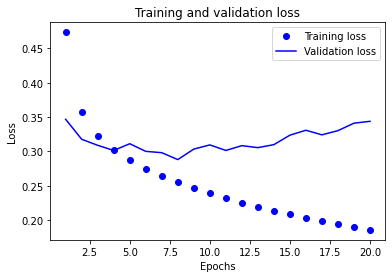

In [25]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

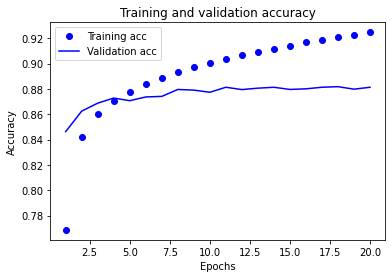

In [26]:
plt.clf()   # 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 분석 추가
* 8차 시도
 * LSTM(256) 1개, Bidirectional(LSTM(256)) 1개 사용
 * vocab_size=10000, word_vector_dim=200, epochs=20, EarlyStopping(X), Dropout(0)
 * batch_size=128
 * val_accuracy:0.87
 

* 앞서 3개의 모델 중 Bidirectional LSTM을 사용.
* 1~2% 성능 향상
* Train과 Validation의 차이를 시각화로 볼 수 있는데 이 차이(간격)가 크다는 것은 Overfitting이 심하다는 것을 알 수 있음.
* Validation_loss는 7epoch 이후부터 올라가는데 overfitting이 시작되는 시점임을 알 수 있음.